# Task Description
The task in the notebook is tackled is sentiment polarity of the sentences mentioning more than one aspects. For the task, again a BERT model used with a slight different manipulation of the data than it is done in category detection. The model used in this notebook is inspired from : Duyu Tang, Bing Qin, Xiaocheng Feng, Ting Liu. 2016. 'Effective LSTMs for Target-Dependent Sentiment Classification'. https://arxiv.org/abs/1512.01100, in which they concatanate two LSTM outcomes for each sentence, which are divided based on the location of the aspect term. 

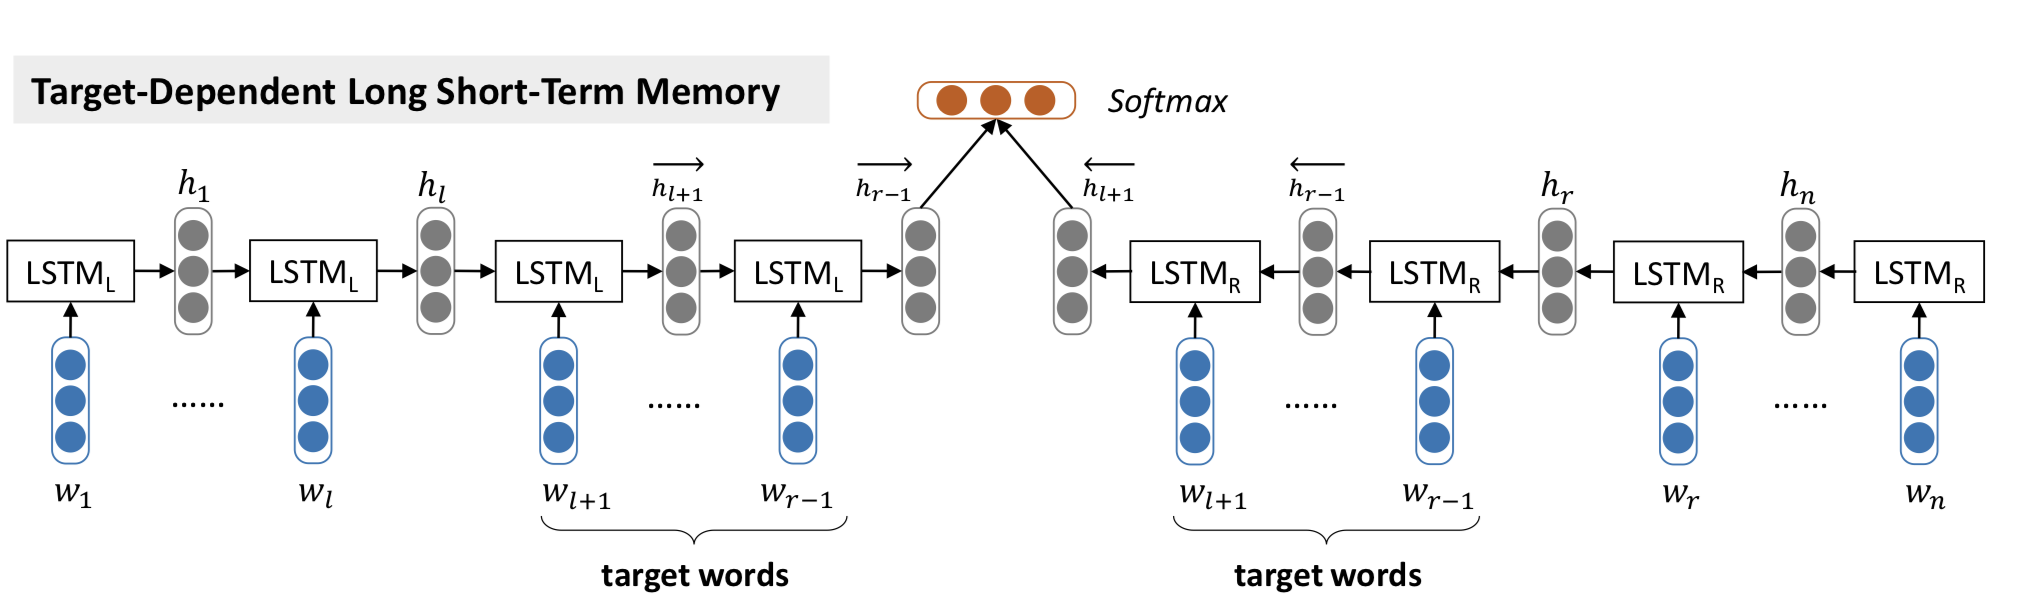

The graphic above shows the target dependent long short-term memory (LSTM) model, they used in the paper. Instead of LSTMs, BERT model is used in this notebook.

![alt text](https://drive.google.com/file/d/1HnS2uZhalTo7T7f_K6yqEzSm9XU7lFwg/view?usp=sharing)

In [ ]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 24.0MB/s 
     |████████████████████████████████| 133kB 31.9MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 7.0MB 19.7MB/s 
ERROR: botocore 1.19.30 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string 
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, hamming_loss, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, FalseNegatives, FalsePositives
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from pytorch_pretrained_bert import BertTokenizer
from tensorflow.keras.models import Model 

# Data Preprocessing

In [ ]:
# Import data
train = pd.read_excel('Trainset.xlsx')
test = pd.read_excel('Testset.xlsx')

# Eliminate the NAs
train = train.fillna('')
test = test.fillna('')

# Remove the rows without Opinion Category values
train = train[train.OpinionCategory != ''] 
test = test[test.OpinionCategory != ''] 

# Sort the data
train = train.sort_values('ID_and_Review').reset_index(drop=True)
test = test.sort_values('ID_and_Review').reset_index(drop=True)

In [ ]:
train.head()

,ID_number,Review_ID,ID_and_Review,OutOfScope,Sentence_ID,OpinionCategory,OpinionFrom,Polarity,AspectTerm,OpinionTo,Text
0,1004293,1,1004293:0,,1,RESTAURANT#GENERAL,51,negative,place,56,Judging from previous posts this used to be a ...
1,1004293,1,1004293:1,,2,SERVICE#GENERAL,75,negative,staff,80,"We, there were four of us, arrived at noon - t..."
2,1004293,1,1004293:2,,3,SERVICE#GENERAL,0,negative,,0,"They never brought us complimentary noodles, i..."
3,1004293,1,1004293:3,,4,FOOD#QUALITY,4,negative,food,8,The food was lousy - too sweet or too salty an...
4,1004293,1,1004293:3,,4,FOOD#STYLE_OPTIONS,52,negative,portions,60,The food was lousy - too sweet or too salty an...


In [ ]:
train.Polarity.value_counts(), test.Polarity.value_counts()

(positive    1657
 negative     749
 neutral      101
 Name: Polarity, dtype: int64, positive    611
 negative    204
 neutral      44
 Name: Polarity, dtype: int64)

Train data consists of 11 variables. The four of them indicate the ID numbers of the sentences, the reviewer, the review and the combination of them. OutofScope variable loses its function when I eliminated the null OpinionCategory values. The Opinion Category shows the aspect which the review refers to. The Opinion Category consists of 12 classes and each class has an entity and a corresponding attribute, in other words, E#A pairs. 

In this notebook, I will deal only with the Polarity and the corresponding reviews under the Text column.

## Multilabeling

In [ ]:
# First, one-hot encode each sentence (duplicate ones as well)
train.Polarity = train.Polarity.astype('category')
one_hot = to_categorical(train.Polarity.cat.codes)
one_hot = pd.DataFrame(one_hot)

test.Polarity = test.Polarity.astype('category')
one_hot_test = to_categorical(test.Polarity.cat.codes)
one_hot_test = pd.DataFrame(one_hot_test)

one_hot.shape, one_hot_test.shape # There are 12 opinion category classes.

((2507, 3), (859, 3))

In [ ]:
# Subtract the necessary columns for the analysis
useful_train = train[['Sentence_ID','Polarity','Text']]
useful_test = test[['Sentence_ID','Polarity','Text']]

# Concatenate the train data and the one-hot-encoding of the opinion category classes.
data_train = pd.concat([useful_train, one_hot], axis=1)
data_test = pd.concat([useful_test, one_hot_test], axis=1)

# Since the reviewer may have mentioned more than one opinion in a sentence, 
# Sum up the one-hot-encoded classes of each sentence.
multi_label = data_train.groupby('Sentence_ID').sum().reset_index(drop=True)
multi_label_test = data_test.groupby('Sentence_ID').sum().reset_index(drop=True)

# In each sentence, an opinion category may be refered more than one.
# Because of that, there were values besides 0 and 1, after the summation.
# Since being refered is important rather than how many times, the values such as 2 or 3 are reverted to one.
multi_label = np.array(multi_label.astype(bool).astype(int))
multi_label_test = np.array(multi_label_test.astype(bool).astype(int))

# After the multi-labeling of the sentences, remove the duplicates.
train_Text = data_train.drop_duplicates(subset=['Sentence_ID'], keep='last').Text
test_Text = data_test.drop_duplicates(subset=['Sentence_ID'], keep='last').Text

multi_label, multi_label.shape, multi_label_test, multi_label_test.shape

(array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]), (1708, 3), array([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        ...,
        [0, 0, 1],
        [1, 0, 1],
        [0, 0, 1]]), (587, 3))

## Data Processing for the BERT Model

In [ ]:
# add special tokens for BERT to work properly
sentences = ["[CLS] " + sent + " [SEP]" for sent in train_Text.astype(str)]
sentences_test = ["[CLS] " + sent + " [SEP]" for sent in test_Text.astype(str)]

sentences[0], sentences_test[0]

('[CLS] Judging from previous posts this used to be a good place, but not any longer. [SEP]',
 '[CLS] Yum! [SEP]')

For the tokenization, pre-trained Bert-Base-Uncased dictionary is used. They constructed it with WordPiece embeddings with a 30,000 token vocabulary. 

In [ ]:
# Tokenize with BERT tokenizer both train and test data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]

tokenized_texts[0], tokenized_texts_test[0]

100%|██████████| 231508/231508 [00:00<00:00, 16659202.40B/s]


(['[CLS]',
  'judging',
  'from',
  'previous',
  'posts',
  'this',
  'used',
  'to',
  'be',
  'a',
  'good',
  'place',
  ',',
  'but',
  'not',
  'any',
  'longer',
  '.',
  '[SEP]'],
 ['[CLS]', 'yu', '##m', '!', '[SEP]'])

For the BERT model to work, we need three inputs. 
- Input IDs: shows the ID number of each token with padding. The ID numbers are restored from the BERT vocabulary dictionary.
- Mask IDs: indicates which elements in the sequence are tokens and which are padding elements.
- Segment IDs: distinguishes different sentences, 0 for one-sentence sequence, 1 if there are two sentences.


In [ ]:
def get_ids(tokens, tokenizer, max_seq_length):
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def get_masks(tokens, max_seq_length):
    if len(tokens) > max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

### Inputs for the before aspect BERT model (left BERT model)

In [ ]:
# find the longest sequence for the padding
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)
    
longestSeq_train = find_max_list(tokenized_texts)
longestSeq_test = find_max_list(tokenized_texts_test)
max_seq_length = max(longestSeq_train, longestSeq_test)
print(max_seq_length)

93


### Inputs for the after aspect BERT model (right BERT model)

In [ ]:
# Find input_ids, mask_ids and segment_ids of the train and test data.
max_seq_length = max_seq_length
input_ids = []
mask_ids = [] 
segments_ids = []
for i in range(len(tokenized_texts)):
    input_ids.append(get_ids(tokenized_texts[i], tokenizer, max_seq_length))
    mask_ids.append(get_masks(tokenized_texts[i], max_seq_length))
    segments_ids.append(get_segments(tokenized_texts[i], max_seq_length))
    
input_ids_test = []
mask_ids_test = [] 
segments_ids_test = [] 
for i in range(len(tokenized_texts_test)):
    input_ids_test.append(get_ids(tokenized_texts_test[i], tokenizer, max_seq_length))
    mask_ids_test.append(get_masks(tokenized_texts_test[i], max_seq_length))
    segments_ids_test.append(get_segments(tokenized_texts_test[i], max_seq_length))
    
# For the model, I converted the lists to tensors.
input_ids = tf.convert_to_tensor(input_ids, dtype = tf.int32)
mask_ids = tf.convert_to_tensor(mask_ids, dtype = tf.int32)
segments_ids = tf.convert_to_tensor(segments_ids, dtype = tf.int32)

input_ids_test = tf.convert_to_tensor(input_ids_test, dtype = tf.int32)
mask_ids_test = tf.convert_to_tensor(mask_ids_test, dtype = tf.int32)
segments_ids_test = tf.convert_to_tensor(segments_ids_test, dtype = tf.int32)

## BERT MODEL

In [ ]:
random.seed(123)
# Three Inputs of the Bert Model
InputIDLayer = Input(shape = (max_seq_length,), dtype = tf.int32, name = "InputIDs")
MaskIDLayer = Input(shape = (max_seq_length,), dtype = tf.int32, name = "MaskIDs")
SegmentIDLayer = Input(shape = (max_seq_length,), dtype = tf.int32, name = "SegmentIDs")

# Import the pre-trained uncased Bert model
bertLayer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=True)

# Since it is a classisfication problem, the pooled output is needed.
pooled_output, sequence_output = bertLayer([InputIDLayer, MaskIDLayer, SegmentIDLayer])
pooled_output = Dropout(0.5)(pooled_output)
output = Dense(units = 768, activation = "tanh")(pooled_output)
output = Dropout(0.5)(output)
output = Dense(units = 12, activation = "softmax")(output)

model = Model(inputs=[InputIDLayer, MaskIDLayer, SegmentIDLayer], outputs = output)

# Model Compilation
learning_rate = 2e-5
number_of_epochs = 10
optimizer = Adam(learning_rate = learning_rate, epsilon = 1e-08)
loss = CategoricalCrossentropy(from_logits = False)
metrics = [Precision(), Recall()]

model.compile(optimizer = optimizer, 
              loss = loss,
              metrics = metrics)

# Model Training & Fine-Tuning on train data
earlyStopping = EarlyStopping(monitor = "val_loss", mode = "min", patience = 1)
checkpoint_path = 'training/cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_best_only = False,
                                                 save_weights_only = True,
                                                 verbose = 1)

bert_history = model.fit([input_ids, mask_ids, segments_ids], [multi_label],
                         epochs = number_of_epochs, 
                         batch_size = 64,
                         validation_split = 0.1,
                         callbacks = [earlyStopping, cp_callback]
                         )

Epoch 1/10


ValueError: ignored

## Performance Graphs

### Loss Graph

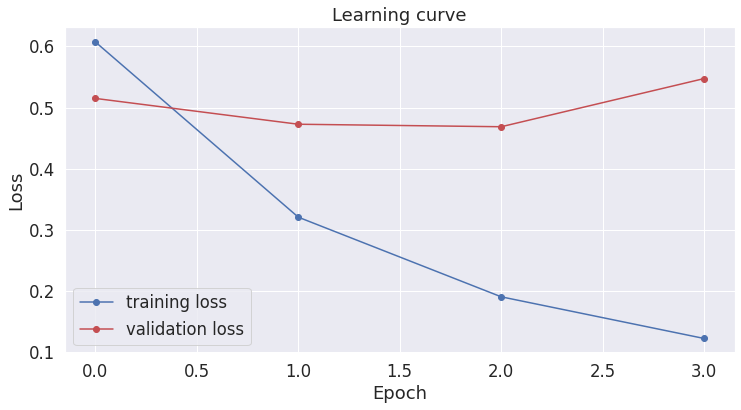

In [ ]:
history_dict = bert_history.history

precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set_style('darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Model Evaluation

### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss

In [ ]:
# Precision, Recall, F1 Score
random.seed(123)
results = model.evaluate([input_ids_before_test, input_masks_before_test, input_segments_before_test,
                          input_ids_after_test, input_masks_after_test, input_segments_after_test], y_test)
f1_score = 2 * (results[1] * results[2])/(results[1] + results[2])

print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))
print("Test F1-Score: {}".format(round(f1_score,3)))

# Predictions
pred_labels = model.predict([input_ids_before_test, input_masks_before_test, input_segments_before_test,
                          input_ids_after_test, input_masks_after_test, input_segments_after_test])

preds = to_categorical(np.argmax(pred_labels, axis=1))

# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(y_test, preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(y_test, preds), 3)))

27/27 [==============================] - 6s 224ms/step - loss: 0.4298 - precision: 0.9406 - recall: 0.3318 - false_negatives: 574.0000 - false_positives: 18.0000
Test Precision: 0.941
Test Recall: 0.332
Test F1-Score: 0.491
Subset accuracy: 0.856
Hamming loss: 0.096


## Label Based Evaluation

### Classification Report

In [ ]:
categories = sorted(train.Polarity.unique())
pred_bools = (preds == 1)
true_bools = (y_test == 1)
clf_report = classification_report(true_bools, pred_bools, target_names=categories
                                   )
print(clf_report)

              precision    recall  f1-score   support

    negative       0.67      0.90      0.77       204
     neutral       0.71      0.23      0.34        44
    positive       0.95      0.89      0.92       611

   micro avg       0.86      0.86      0.86       859
   macro avg       0.78      0.67      0.68       859
weighted avg       0.87      0.86      0.85       859
 samples avg       0.86      0.86      0.86       859



### Confusion Matrices

Confusion matrix for label 0:
[[566  89]
 [ 21 183]]
Recall: 0.96
Precision: 0.86
F1 Score: 0.91
ROC/AUC Score: 0.88
Sensitivity: 0.9
Specificity: 0.86

Confusion matrix for label 1:
[[811   4]
 [ 34  10]]
Recall: 0.96
Precision: 1.0
F1 Score: 0.98
ROC/AUC Score: 0.88
Sensitivity: 0.23
Specificity: 1.0

Confusion matrix for label 2:
[[217  31]
 [ 69 542]]
Recall: 0.76
Precision: 0.88
F1 Score: 0.81
ROC/AUC Score: 0.88
Sensitivity: 0.89
Specificity: 0.88



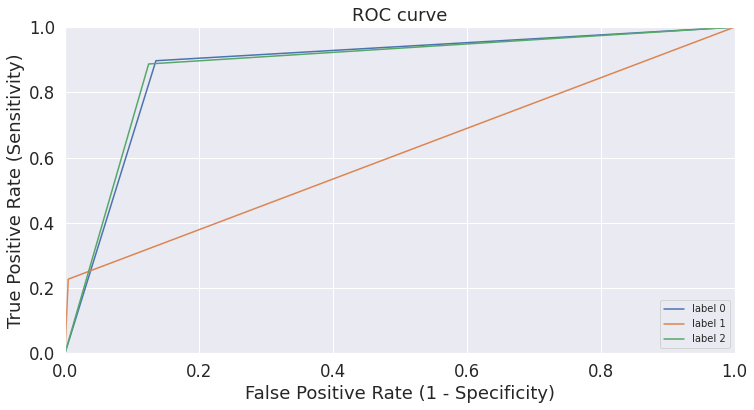

In [ ]:
# Confusion Matrices
# Setting the threshold as 0.10

labels = range(3)

# Confusion Matrices
conf_mat_dict={}

for label_col in labels:
    y_true_label = y_test[:, label_col]
    y_pred_label = preds[:, label_col]
    conf_mat_dict.setdefault(label_col,[]).append(confusion_matrix(y_pred=y_pred_label, y_true=y_true_label))
    conf_mat_dict.setdefault(label_col,[]).append(y_true_label)
    conf_mat_dict.setdefault(label_col,[]).append(y_pred_label)

for label, values in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    matrix = values[0]
    print(matrix)
    recall = matrix[0][0] / (matrix[0][0] + matrix[1][0])
    print("Recall: {}".format(round(recall, 2)))
    precision = matrix[0][0] / (matrix[0][0] + matrix[0][1])
    print("Precision: {}".format(round(precision, 2)))
    f1_score =  2 * (precision * recall)/(precision + recall)
    print("F1 Score: {}".format(round(f1_score, 2)))
    true_label = values[1]
    pred_label = values[2]
    
    print("ROC/AUC Score: {}".format(round(roc_auc_score(y_true_label, y_pred_label),2)))
    fp, tp, thresholds = roc_curve(true_label, pred_label)
    def evaluate_threshold(tpr, fpr,clf_threshold, threshold):
      print('Sensitivity:', round(tp[thresholds > threshold][-1],2))
      print('Specificity:', 1 - round(fp[thresholds > threshold][-1],2))
    evaluate_threshold(tp, fp, thresholds, 0.1)
    print()
    plt.plot(fp, tp, label="label {}". format(label))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)  

The label names corresponding to the indexes:
- 0: negative
- 1: neutral
- 2: positive

## Output Frame

In [ ]:
# Convert the boolean vectors to the prediction indexes
true_label_idxs, pred_label_idx =[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools:
  pred_label_idx.append(np.where(vals)[0].flatten().tolist())

# Convert the indexes to label names
idx2label = dict(zip(range(3),categories))
true_label_texts, pred_label_texts= [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in pred_label_idx:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

# Converting lists to df
polarity_df = pd.DataFrame({'comment_text': test.Text, 'true_labels': true_label_texts, 'true_codes':true_label_idxs,
                            'polarity_labels':pred_label_texts, 'polarity_codes':pred_label_idx})
polarity_df.to_csv('polarity_df.csv')
polarity_df.to_excel('polarity_df.xlsx')
polarity_df.head()

,comment_text,true_labels,true_codes,polarity_labels,polarity_codes
0,Yum!,[positive],[2],[positive],[2]
1,Serves really good sushi.,[positive],[2],[positive],[2]
2,Not the biggest portions but adequate.,[neutral],[1],[negative],[0]
3,Green Tea creme brulee is a must!,[positive],[2],[positive],[2]
4,Don't leave the restaurant without it.,[positive],[2],[negative],[0]
